In [112]:
%load_ext autoreload
%autoreload 2
# Gestion de rutas
import utils.paths as path
# Importacion de librerías
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import requests
import os
import re
# Directorio de los datos crudos / raw data
raw_data_dir = path.make_dir_function(['datasets', 'raw'])
pros_data_dir = path.make_dir_function(['datasets', 'processed'])
inte_data_dir = path.make_dir_function(['datasets', 'interim'])

roy_data_dir = path.make_dir_function(['roy','datasets','prosseced'])
jaime_dir = path.make_dir_function(['jaime','data','finale_dataset'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
# Lectura de los datsets
noise_poll = pd.read_csv(pros_data_dir('noise_pollution.csv'))
vehicule_density = pd.read_csv(jaime_dir('vehicular_volume.csv'))

* Nota: Se considera una ventana temporal de tres años (2016 al 2019)

In [115]:
# Lectura del dataset Volumen vehicular
vehicule_density = vehicule_density.iloc[::, 1:]
vehicule_density['year'] = pd.to_datetime(vehicule_density['date']).dt.year

In [116]:
# Filtro de fecha del 2016 al 2019
vehicule_density = vehicule_density[(vehicule_density['year'] <= 2019) & (vehicule_density['year'] >= 2016)]

In [117]:
# Conversion de la métrica del volumen vehicular en días
vehicule_density.loc[::,'volume'] = (vehicule_density.loc[::,'volume'])*(4*24)

In [118]:
# Union de los datasets a través del identificador de borough
data_v0 = pd.merge(vehicule_density[['date','id_borough','volume']], noise_poll, left_on='id_borough',right_on='borough_id')

In [119]:
# Eliminando la columna id_borough
data_v0 = data_v0.drop('id_borough', axis=1)
# Convertir la columna de fecha a datetime
data_v0['date'] = pd.to_datetime(data_v0['date'], format='%Y-%m-%d')

### 1. Análisis de la correlacion de las variables de volumen vehicular, cantidad de sonidos procedentes de motores y cantidad de sonidos procedentes señales de alerta

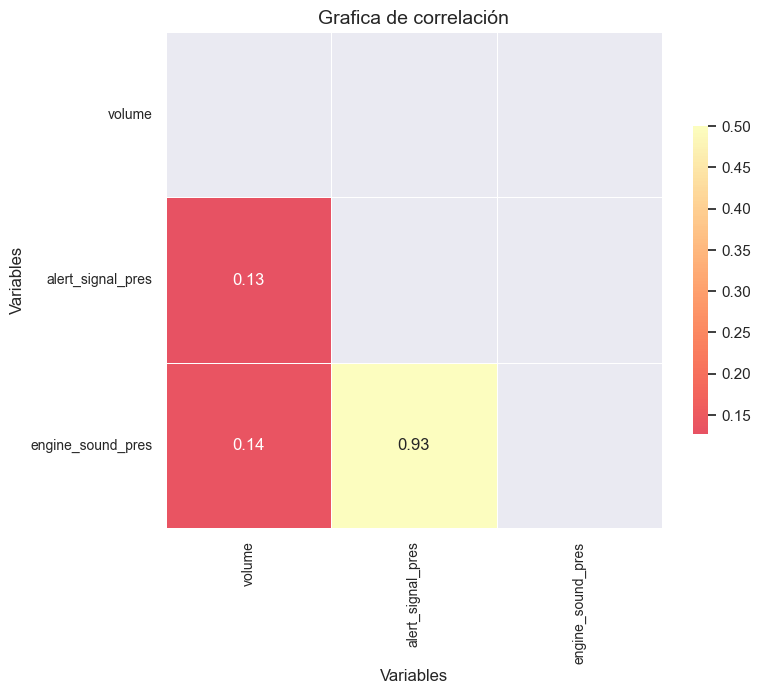

In [120]:
sns.set_theme(style = 'darkgrid')

corr_matrix = data_v0[['volume','alert_signal_pres','engine_sound_pres']].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype = bool))

fig, ax = plt.subplots(figsize = (8, 8))

sns.heatmap(corr_matrix, mask = mask, cmap = 'magma', vmax = 0.5, center = 0, square = True, linewidths = 0.5, cbar_kws = {"shrink": 0.5}, annot=True)

# Añadir etiquetas a los ejes
ax.set_xlabel("Variables", fontsize=12)
ax.set_ylabel("Variables", fontsize=12)

# Personalizar los tickets en ambos ejes
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

# Añadir título a la figura
ax.set_title("Grafica de correlación", fontsize=14)

plt.show()

* Se observa una correlación alta entre las variables ``engine_sound_pres`` y ``alert_signal_pres``, lo que implica que la presencia de un sonido proveniente de un motor de un vehículo está relacionado con la presencia de un sonido cuyo fuente es una señal de alerta.

### 2. KPI: Medición del ratio de sonidos registrados por volumen de tráfico diriamente

Definiremos dos métricas:
1. **rat_soundeng_voltraf**: Ratio sonidos registrados de motores por volumen de tráfico diariamente.
2. **rat_alertsig_voltraf**: Ratio sonidos registrados de señales de alerta por volumen de tráfico diariamente.

Mientras mayor sea el **rat_soundeng_voltraf** y **rat_alertsig_voltraf** implica que a mayor cantidad de vehículos que transitan en un día, se registran mayor cantidad de sonidos que provienen de los motores o señales de alerta, respectivamente. El objetivo de implementar un flota vehicular que mitigue el problema de la contaminación acústica es reducir los ratios mencionados, de tal forma que tengamos un gran volumen de automovil transitando al día y se reduzcan la presencia de sonidos provenientes de motores y señales de alerta.

Variables que consideraremos para estudiar la contaminación acústica:

* volume: Cantidad de vehículos que transitan por un día (24 horas).
* alert_signal_pres: Cantidad de registro de sonidos provenientes del motor de un vehículo por día
* engine_sound_pres: Cantidad de registro de sonidos provenientes del señales de alarma por día

In [121]:
# Calculo del ratio sonidos registrados de motores por volumen de tráfico diariamente
data_v0['rat_soundeng_voltraf'] = data_v0['volume'] / data_v0['engine_sound_pres']
# Cálculo del ratio sonidos registrados de señales de alerta por volumen de tráfico diariamente.
data_v0['rat_alertsig_voltraf'] = data_v0['volume'] / data_v0['alert_signal_pres']

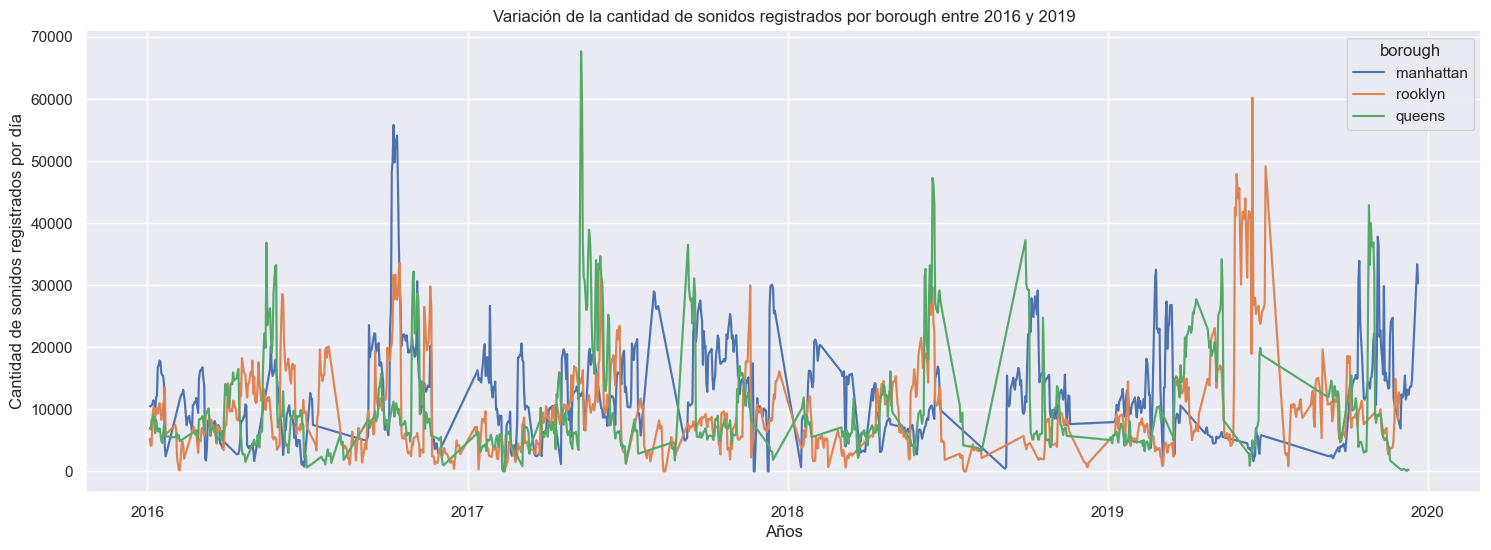

In [95]:
# Seleccionar las columnas relevantes del dataframe
count_sound_cols = ['volume', 'alert_signal_pres', 'engine_sound_pres', 'borough', 'date']
# Definir figura y tamaño
plt.figure(figsize=(18, 6))

# Graficar datos
sns.lineplot(data=data_v0[count_sound_cols],
             x='date',
             y='volume',
             hue='borough')

# Formatear eje X
date_format = mdates.DateFormatter('%Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Titulo del grafico
plt.title(f"Variación de la cantidad de sonidos registrados por borough entre {data_v0['date'].dt.year.min()} y {data_v0['date'].dt.year.max()}")

# Etiquetas de ejes
plt.xlabel('Años')
plt.ylabel('Cantidad de sonidos registrados por día')

plt.show()

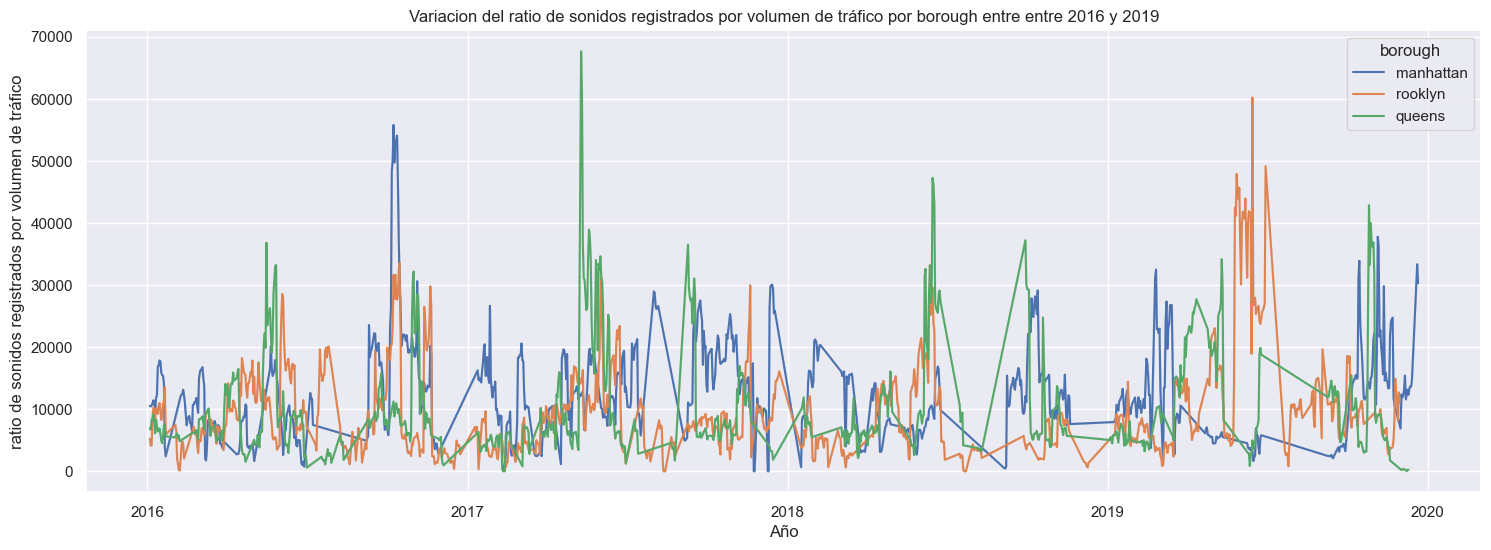

In [107]:
# Seleccionar las columnas relevantes del dataframe
rat_cols = ['volume', 'rat_soundeng_voltraf', 'rat_alertsig_voltraf', 'borough', 'date']

# Definir figura y tamaño
plt.figure(figsize=(18, 6))

# Graficar datos
sns.lineplot(data=data_v0[rat_cols], x='date', y='volume', hue='borough')

# Formatear eje X
date_format = mdates.DateFormatter('%Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Titulo del grafico
plt.title(f"Variacion del ratio de sonidos registrados por volumen de tráfico por borough entre entre {data_v0['date'].dt.year.min()} y {data_v0['date'].dt.year.max()}")

# Etiquetas de ejes
plt.xlabel('Año')
plt.ylabel('ratio de sonidos registrados por volumen de tráfico')

plt.show()

In [111]:
# Exrportamos la data
data_v0.to_csv(roy_data_dir('kpi_noisepoll_vehtraffic.csv'), index='False')